In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [80]:
orders = pd.read_csv('orders.csv', sep=';')

In [81]:
items = pd.read_csv('items.csv', sep=';')

## Orders EDA

In [12]:
orders.head()

,order_id,date,payment,item_code,quantity,gift_quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,channel,owner,site,CreatedAt
0,2000093387,2020-04-24 00:00:00,GOPAY_CARD,S101,1,NaN,3.506048,0.000000,3.496395,E-COMMER,RUN.huC,RUN.huO,top4running.hu,2020-04-24 21:50:00
1,2000093387,2020-04-24 00:00:00,GOPAY_CARD,S113,1,NaN,-0.705913,0.000000,-0.717209,E-COMMER,RUN.huC,RUN.huO,top4running.hu,2020-04-24 21:50:00
2,2000093388,2020-04-24 00:00:00,COD,ZB00089178,1,NaN,5.829845,2.209302,6.472868,E-COMMER,FTB.czC,FTB.czO,11teamsports.cz,2020-04-24 21:45:00
3,2000093388,2020-04-24 00:00:00,COD,ZB00138060,1,NaN,5.829845,2.209302,6.472868,E-COMMER,FTB.czC,FTB.czO,11teamsports.cz,2020-04-24 21:45:00
4,2000093388,2020-04-24 00:00:00,COD,ZB00015664,1,NaN,19.379845,18.731008,32.015504,E-COMMER,FTB.czC,FTB.czO,11teamsports.cz,2020-04-24 21:45:00


In [13]:
orders.shape

(2128524, 14)

In [14]:
orders.describe()

,order_id,quantity,gift_quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl
count,2.128524e+06,2.128524e+06,10390.000000,2.128524e+06,2.128524e+06,2.128426e+06
mean,2.039053e+09,1.029551e+00,1.000192,3.102203e+01,1.903846e+01,3.942803e+01
std,7.691450e+07,5.852888e-01,0.019621,4.066967e+01,2.665736e+01,5.013470e+01
min,2.000000e+07,-1.000000e+00,1.000000,-1.859721e+00,0.000000e+00,-1.771163e+00
25%,2.000112e+09,1.000000e+00,1.000000,2.551573e+00,0.000000e+00,2.613605e+00
50%,2.100026e+09,1.000000e+00,1.000000,1.442870e+01,7.829457e+00,2.034849e+01
75%,2.100322e+09,1.000000e+00,1.000000,4.481395e+01,2.871260e+01,5.810465e+01
max,2.200024e+09,1.360000e+02,3.000000,7.203857e+02,2.440504e+03,7.444543e+02


In [15]:
orders.isnull().sum()

order_id                     0
date                         0
payment                    567
item_code                    0
quantity                     0
gift_quantity          2118134
unit_price_vat_excl          0
unit_cogs                    0
unit_rrp_vat_excl           98
department                   0
channel                      0
owner                        0
site                         0
CreatedAt                    0
dtype: int64

##### Must look into why there are null values in payment column
##### Must look into why there can be negative unit price and RRP

In [16]:
print(f"Order date range: {orders['date'].min()} to {orders['date'].max()}")

Order date range: 2019-06-01 00:00:00 to 2022-01-14 00:00:00


In [17]:
for col in orders:
    print(f'{orders[col].value_counts()} \n')

2100248254    76
2100068062    53
2000271974    50
2100066795    46
2000187597    44
              ..
2100190797     1
2100190796     1
2100190789     1
2100190786     1
521011438      1
Name: order_id, Length: 925050, dtype: int64 

2021-11-28 00:00:00    8219
2021-12-13 00:00:00    7801
2021-12-14 00:00:00    7536
2021-12-12 00:00:00    7518
2021-12-15 00:00:00    7287
                       ... 
2019-06-03 00:00:00      50
2019-06-02 00:00:00       9
2019-06-16 00:00:00       6
2019-06-15 00:00:00       5
2019-06-08 00:00:00       4
Name: date, Length: 958, dtype: int64 

COD                    1239267
GOPAY_CARD              253689
PAYPAL                  226131
CARD_GOPAY              198801
CARD_CSOB               115246
CHECKOUT_CARD            84398
PAYPAL_EXPRESS            5322
CHECKOUT_APPLE            2626
CHECKOUT_IDEAL            1388
CHECKOUT_BANCONTACT        551
BANK_TRANSFER              356
CASH                        73
ZALOHA                      32
CSOB_CARD      

##### Must look into most frequent item_codes (S101, S113, S114)
##### Must look into difference between channel and owner
##### Department column does not contain meaningful information, can be dropped
##### Must look into what it means when "site" is Other

In [18]:
payfilter = orders['payment'].isna()
# orders[filter]
orders[payfilter]['date'].value_counts()

2022-01-14 00:00:00    563
2021-07-12 00:00:00      1
2021-07-26 00:00:00      1
2021-07-27 00:00:00      1
2021-07-29 00:00:00      1
Name: date, dtype: int64

##### Can drop these rows, majority of nulls occurring on one day suggests payment processor outage

In [19]:
filters = orders['item_code']=='S113'
orders[filters]

,order_id,date,payment,item_code,quantity,gift_quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,channel,owner,site,CreatedAt
1,2000093387,2020-04-24 00:00:00,GOPAY_CARD,S113,1,NaN,-0.705913,0.0,-0.717209,E-COMMER,RUN.huC,RUN.huO,top4running.hu,2020-04-24 21:50:00
7,2000093388,2020-04-24 00:00:00,COD,S113,1,NaN,0.929070,0.0,0.930233,E-COMMER,FTB.czC,FTB.czO,11teamsports.cz,2020-04-24 21:45:00
10,2000093389,2020-04-24 00:00:00,COD,S113,1,NaN,0.929070,0.0,0.930233,E-COMMER,FTB.czC,FTB.czO,11teamsports.cz,2020-04-24 21:50:00
13,2000093390,2020-04-24 00:00:00,CARD_CSOB,S113,1,NaN,-0.640698,0.0,-0.658915,E-COMMER,FTB.czC,FTB.czO,11teamsports.cz,2020-04-24 21:50:00
16,2000093391,2020-04-24 00:00:00,COD,S113,1,NaN,0.843585,0.0,0.843585,E-COMMER,FTB.skC,FTB.skO,11teamsports.sk,2020-04-24 21:50:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128448,2200024140,2022-01-14 00:00:00,NaN,S113,1,NaN,0.748969,0.0,0.748969,E-COMMER,FIT.skC,FIT.skO,top4fitness.sk,2022-01-14 10:55:00
2128451,2200024142,2022-01-14 00:00:00,NaN,S113,1,NaN,0.929070,0.0,0.930233,E-COMMER,RUN.czC,RUN.czO,top4running.cz,2022-01-14 10:55:00
2128455,2200024143,2022-01-14 00:00:00,NaN,S113,1,NaN,0.805326,0.0,0.766977,E-COMMER,11TS.roC,11TS.roO,11teamsports.ro,2022-01-14 11:00:00
2128461,2200024147,2022-01-14 00:00:00,NaN,S113,1,NaN,0.805326,0.0,0.766977,E-COMMER,11TS.roC,11TS.roO,11teamsports.ro,2022-01-14 11:00:00


In [20]:
filters = orders['unit_price_vat_excl'] < 0
orders[filters]['item_code'].value_counts()

S113    34180
Name: item_code, dtype: int64

##### These appear to be returns, do we keep returns to calculate revenue or drop for creating sales model?

In [21]:
filters = orders['site']=='other'
orders[filters]

,order_id,date,payment,item_code,quantity,gift_quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,channel,owner,site,CreatedAt
138420,1170259775,2021-07-26 00:00:00,NaN,S121,1,NaN,0.009942,0.0,NaN,E-COMMER,ECOMothC,ECOMothO,other,2021-07-26 11:45:00
138421,1170261413,2021-07-27 00:00:00,NaN,S121,1,NaN,0.009934,0.0,NaN,E-COMMER,ECOMothC,ECOMothO,other,2021-07-27 13:18:00
138422,1170264127,2021-07-29 00:00:00,NaN,S121,1,NaN,0.009932,0.0,NaN,E-COMMER,ECOMothC,ECOMothO,other,2021-07-29 20:21:00
138423,119002439,2019-08-12 00:00:00,DOBIRKA,S121,1,NaN,0.090105,0.0,NaN,E-COMMER,ECOMothC,ECOMothO,other,2019-08-12 13:35:00
138424,119003283,2019-06-30 00:00:00,PREVOD_SBER,S121,1,NaN,0.008915,0.0,NaN,E-COMMER,ECOMothC,ECOMothO,other,2019-06-30 08:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128519,521008740,2021-10-11 00:00:00,ZALOHA,S121,1,NaN,0.028682,0.0,NaN,E-COMMER,ECOMothC,ECOMothO,other,2021-10-11 14:10:00
2128520,521009376,2021-10-26 00:00:00,DOBIRKA,S121,1,NaN,0.030620,0.0,NaN,E-COMMER,ECOMothC,ECOMothO,other,2021-10-26 21:04:00
2128521,521009994,2021-11-11 00:00:00,ZALOHA,S121,1,NaN,0.022481,0.0,NaN,E-COMMER,ECOMothC,ECOMothO,other,2021-11-11 13:03:00
2128522,521011437,2021-12-23 00:00:00,ZALOHA,S121,1,NaN,0.005039,0.0,0.0,E-COMMER,ECOMothC,ECOMothO,other,2021-12-23 15:58:00


## Items EDA

In [22]:
items.head()

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
0,ZB00210807,Studio Metallic LS Top,51951501,86,Puma,200.0,Apparel,230.0,T-Shirts,233.0,Longsleeved (LS) shirts,fitness,women,adults,Black,L
1,ZB00210813,TRAIN TECH EVOKNIT SS TEE,52011101,86,Puma,200.0,Apparel,230.0,T-Shirts,0.0,NaN,fitness,men,adults,Black,S
2,ZB00210815,TRAIN TECH EVOKNIT SS TEE,52011123,86,Puma,200.0,Apparel,230.0,T-Shirts,0.0,NaN,fitness,men,adults,Orange,L
3,ZB00210821,TRAIN TECH EVOKNIT SS TEE,52011130,86,Puma,200.0,Apparel,230.0,T-Shirts,0.0,NaN,fitness,men,adults,Yellow,XL
4,ZB00261295,LIGA Baselayer Tee LS,655920-027,86,Puma,200.0,Apparel,230.0,T-Shirts,233.0,Longsleeved (LS) shirts,football,men,adults,Green,L


In [23]:
items.shape

(309128, 16)

In [24]:
items.describe()

,brand_id,group0_id,group1_id,group2_id
count,309128.000000,309093.000000,301709.000000,301709.000000
mean,96.129768,174.490247,168.309994,49.662135
std,35.064212,141.565159,86.074512,93.666764
min,-1.000000,0.000000,0.000000,0.000000
25%,84.000000,100.000000,110.000000,0.000000
50%,85.000000,200.000000,199.000000,0.000000
75%,93.000000,200.000000,230.000000,0.000000
max,263.000000,999.000000,999.000000,327.000000


In [25]:
items.isnull().sum()

item_code         0
item_name      3126
style          6797
brand_id          0
name              0
group0_id        35
group0          826
group1_id      7419
group1        43780
group2_id      7419
group2       237355
category      39846
gender         7484
age            7566
color         45596
size           8041
dtype: int64

##### Many nulls, item_name and style are the most important to look into

In [26]:
items['item_name'].value_counts()

DUPLICITNÍ ARTIKL                         427
UA Classic Slip-On                        397
GEL-NIMBUS 23                             343
React Infinity Run Flyknit 2              328
NIKE AIR ZOOM PEGASUS 36                  323
                                         ... 
Under Armour AF Graphic                     1
FFF Strike                                  1
U NK HERTHA BSC HOME DRY SOCKS 2020/21      1
Borussia Dortmund Away 2019/20              1
iPhone 7 32GB Black                         1
Name: item_name, Length: 33788, dtype: int64

In [27]:
items['style'].value_counts()

DUPLICITNÍ ARTIKL    186
907564-017            31
vn000d5invy1          30
aq4184-010            30
907566-017            27
                    ... 
928983-010             1
e099ha00               1
1326799-486            1
365340-002             1
ZB00025686             1
Name: style, Length: 65200, dtype: int64

In [28]:
filters = items['item_name'].isna()
# items[filters]
items[filters]['style'].value_counts()

3023633-103    10
3024968-300    10
3023633-302    10
3024272-300     9
3024155-603     8
3023633-004     4
3024271-103     3
3023633-001     2
724762-010      2
3023738-003     2
sx4854-070      1
934305-100      1
3023698-001     1
3024701-101     1
3024223-103     1
3023738-002     1
3024764-404     1
3023695-400     1
3024764-106     1
3024915-101     1
3024272-001     1
Name: style, dtype: int64

In [29]:
filters = items['style'].isna()
# items[filters]
items[filters]['item_name'].value_counts()

GEL-NIMBUS 23             100
GEL-CUMULUS 22             68
GT-2000 9                  67
GEL-KAYANO 27              61
GlideRide 2                49
                         ... 
bau-sweater-man-russel      1
='[1]Vlook up'!E40          1
cas-atlet-1-2020            1
='[1]Vlook up'!E48          1
iPhone 7 32GB Black         1
Name: item_name, Length: 1056, dtype: int64

In [30]:
filters = items['item_code']=='S101'
items[filters]

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
306868,S101,Dopravné,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
filters = items['item_code']=='S113'
items[filters]

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
307919,S113,Platba,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
filters = items['item_code']=='S114'
items[filters]

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
308992,S114,Sleva,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
filters = items['item_code']=='ZB00077277'
items[filters]

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
285821,ZB00077277,Nike Everyday 3 pack,sx7676-100,84,Nike,200.0,Apparel,290.0,Socks,0.0,NaN,football,men,adults,White,M


In [34]:
filters = items['item_code']=='ZB00053597'
items[filters]

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
269154,ZB00053597,Nike Everyday 3 pack,sx7676-100,84,Nike,200.0,Apparel,290.0,Socks,0.0,NaN,football,men,adults,White,L


In [35]:
filters = (items['item_name']=='GEL-NIMBUS 23')
items[filters].head()

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
72904,ZB00186782,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73749,ZB00186781,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74974,ZB00186776,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74975,ZB00186778,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75438,ZB00186777,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
filters = (items['item_name']=='GEL-NIMBUS 23') & (items['size'].isna())
items[filters]

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
72904,ZB00186782,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73749,ZB00186781,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74974,ZB00186776,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74975,ZB00186778,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75438,ZB00186777,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141099,ZB00186465,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141324,ZB00186352,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141480,ZB00186474,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141481,ZB00186475,GEL-NIMBUS 23,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
techfilter = items['group0_id'].isna()
items[techfilter]

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
108430,ZB00308133,voucher-t4r-50-eur-de,voucher-t4r-50-eur-de,87,Topforsport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,ks
111837,ZB00308709,voucher-t4r-50-eur-es,voucher-t4r-50-eur-es,87,Topforsport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,ks
305358,DRM0361,Notebook HP ProBook 450 G8,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305479,S128,Poukaz_uplatnení,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305946,DRM0060,Notebook Lenovo ThinkPad 13,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305959,DRM0349,IPHONE SE RED 64GB-CSC,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306226,DRM0358,Notebook Lenovo IdealPad 3 15ITL6,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306243,DRM0344,Notebook Lenovo IdeaPad S340,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306541,S134,Marketingový príspevek_fa pred,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306586,DRM0359,Notebook Lenovo IdealPad 5 15ARE5 Platinum Grey,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Can drop these rows, they are not regular products carried by Top4Sport

In [38]:
filters = items['brand_id']==-1
items[filters]

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
12505,ZB00000222,Xfer Montecarlo,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12661,ZB00000224,"Multifunkcní batoh Hamelin, cerná",NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13255,ZB00000221,Xfer Montecarlo,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16808,ZB00000223,Xfer Montecarlo,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50614,ZB00186641,DYNABLAST,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309123,ZB00073434,NaN,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309124,ZB00075104,NaN,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309125,ZB00073523,NaN,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309126,ZB00165469,NaN,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
filters = orders['item_code']=='ZB00000223'
orders[filters]

,order_id,date,payment,item_code,quantity,gift_quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,channel,owner,site,CreatedAt


## Data Cleaning for Visualization

In [82]:
# drop null payment rows
payfilter = orders['payment'].isna()
orders.drop(orders[payfilter].index, inplace=True)

# drop items that are not sold by Top4Sport
techfilter = items['group0_id'].isna()
items.drop(items[techfilter].index, inplace=True)

In [83]:
# create columns used for visualizations
orders['date']=pd.to_datetime(orders['date'])
orders['net_revenue'] = orders['quantity'] * orders['unit_price_vat_excl']
orders['gross_revenue'] = orders['quantity'] * orders['unit_rrp_vat_excl']
orders['net_profit'] = orders['quantity'] * (orders['unit_price_vat_excl'] - orders['unit_cogs'])

In [84]:
# drop 'other' sites because almost no information loss
orders.drop(orders[orders['site']=='other'].index, inplace=True)
# extract site country domain and create new country column
orders['country']=orders['site'].apply(lambda x: x.split('.')[1])
# drop .com domains because almost no information loss and company based in Europe
orders.drop(orders[orders['country']=='com'].index, inplace=True)
# map domain to country
orders['country']=orders['country'].replace(
    {'cz':'Czech Republic', 'de':'Germany', 'es':'Spain', 'hr': 'Croatia',  'it': 'Italy',
     'fr':'France',  'hu':'Hungary', 'at':'Austria', 'ie':'Ireland', 'ro':'Romania', 'sk':'Slovakia',
     'dk':'Denmark', 'nl':'Netherlands', 'se':'Sweden', 'pt':'Portugal', 'pl':'Poland',
     'be':'Belgium', 'fi':'Finland', 'si':'Slovenia', 'uk':'United Kingdom', 'bg':'Bulgaria'
})
# drop unnecessary order columns
order_df=orders.drop(['payment','unit_rrp_vat_excl', 'department', 'channel', 'owner', 'site', 'CreatedAt', 'gift_quantity'], axis=1)
# drop unnecessary item columns
items_df=items.drop(['brand_id','group0_id', 'group1_id', 'group2_id'], axis=1)

In [85]:
viz_df=pd.merge(order_df, items_df, how='left', on='item_code')

In [86]:
viz_df.isnull().sum()

order_id                     0
date                         0
item_code                    0
quantity                     0
unit_price_vat_excl          0
unit_cogs                    0
net_revenue                  0
gross_revenue               69
net_profit                   0
country                      0
item_name                   46
style                   760277
name                        41
group0                     428
group1                  792154
group2                 1710921
category                765470
gender                  760529
age                     760550
color                   794366
size                    760816
dtype: int64

In [87]:
viz_df['group0'].fillna('Other', inplace=True)
viz_df['category'].fillna('other', inplace=True)

## Visualizations

##### S101 Dopravné translates to Freight. 

##### žádný výrobce translates to no manufacturer.

##### S113 Platba translates to Payment

##### S114 Sleva translates to Discount

##### What is the most popular brand
##### Most popular category
##### Most popular product
##### Free shipping on website, how is it reflected on these df
##### Is there any indication of when a product was added

In [46]:
viz_df.columns

Index(['order_id', 'date', 'item_code', 'quantity', 'unit_price_vat_excl',
       'unit_cogs', 'net_revenue', 'gross_revenue', 'profit_margin', 'country',
       'item_name', 'style', 'name', 'group0', 'group1', 'group2', 'category',
       'gender', 'age', 'color', 'size'],
      dtype='object')

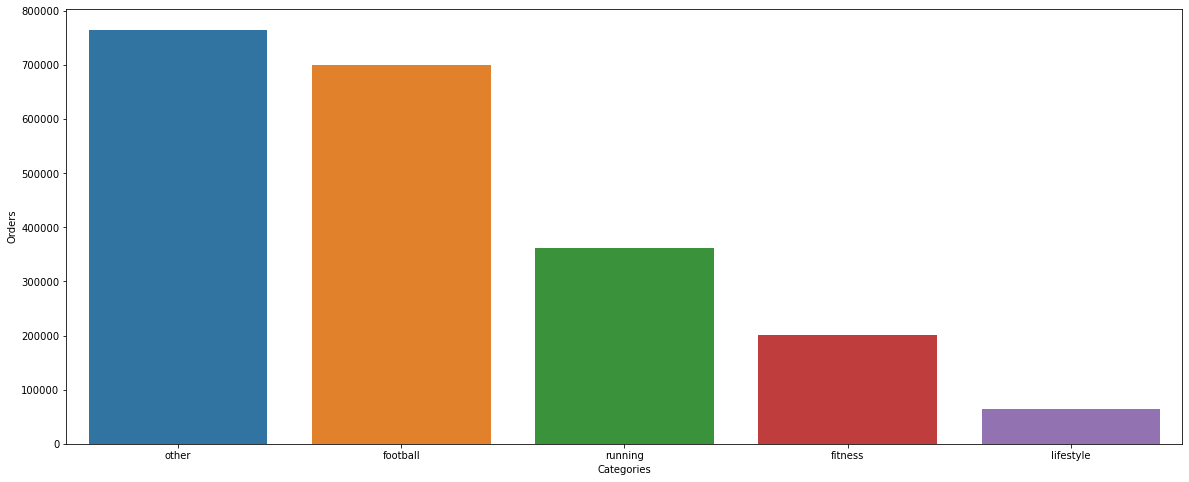

In [47]:
category_viz = viz_df['category'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(category_viz.index, category_viz.values)
plt.ylabel('Orders')
plt.xlabel('Categories')
plt.show()

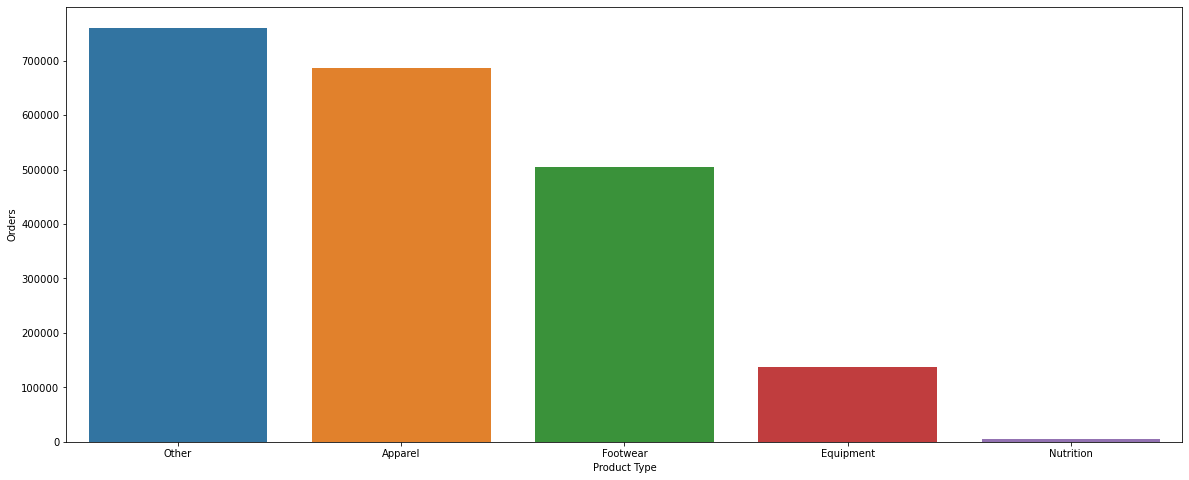

In [48]:
product_type_viz = viz_df['group0'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(product_type_viz.index, product_type_viz.values)
plt.ylabel('Orders')
plt.xlabel('Product Type')
plt.show()

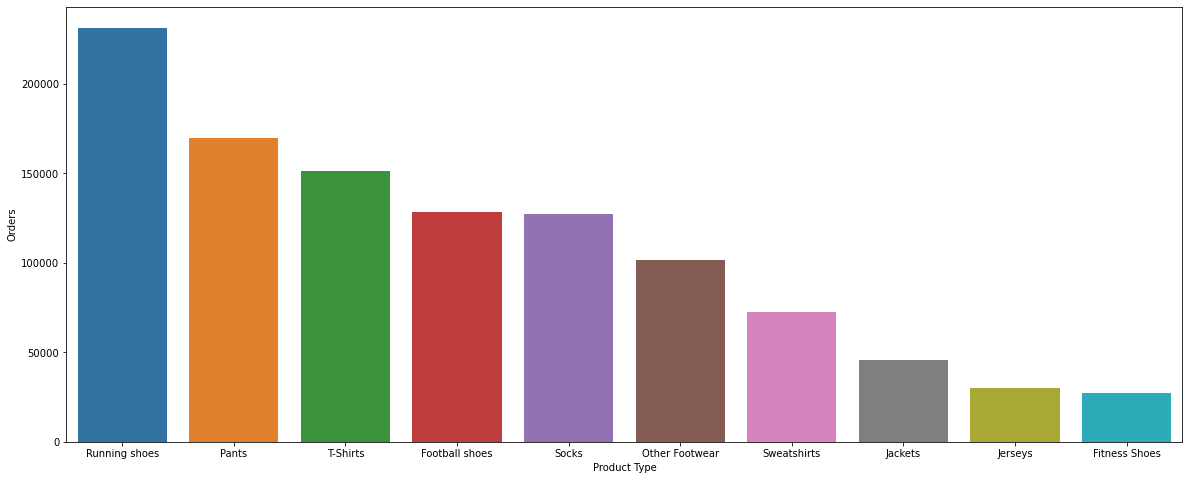

In [49]:
product_type_viz = viz_df['group1'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(product_type_viz.index[:10], product_type_viz.values[:10])
plt.ylabel('Orders')
plt.xlabel('Product Type')
plt.show()

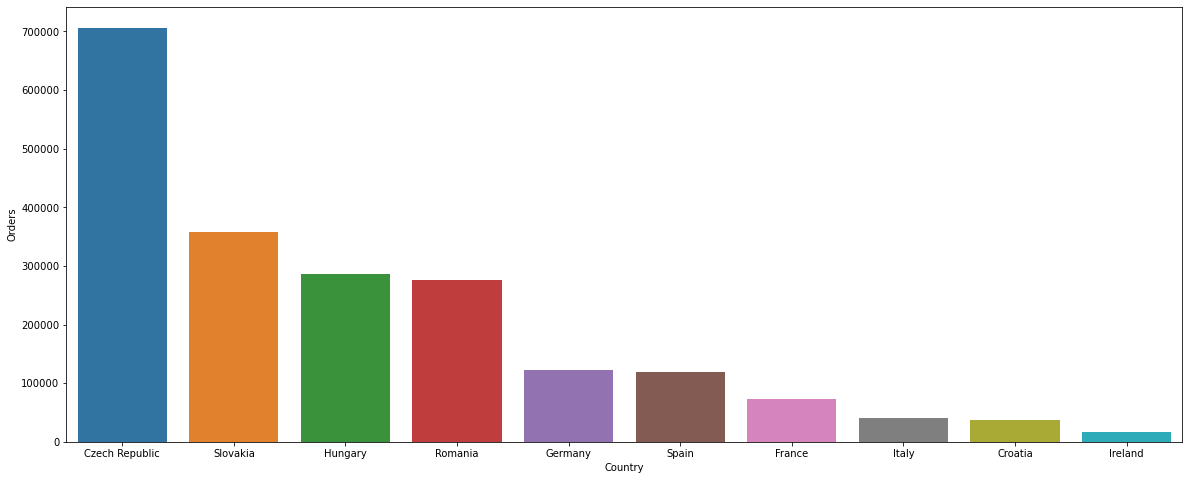

In [50]:
country_viz = viz_df['country'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(country_viz.index[:10], country_viz.values[:10])
plt.ylabel('Orders')
plt.xlabel('Country')
plt.show()

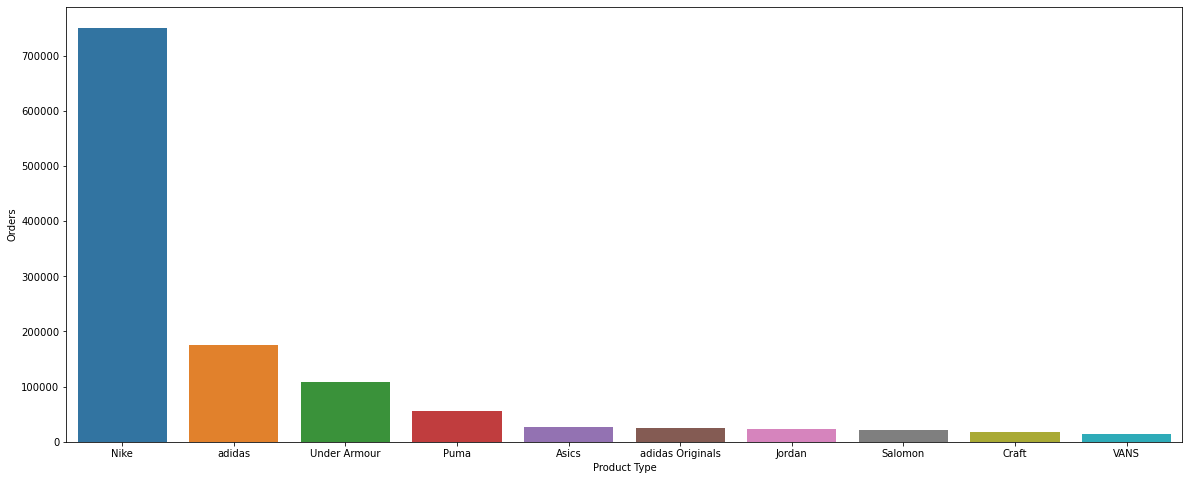

In [51]:
brand_viz = viz_df['name'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(brand_viz.index[1:11], brand_viz.values[1:11])
plt.ylabel('Orders')
plt.xlabel('Product Type')
plt.show()

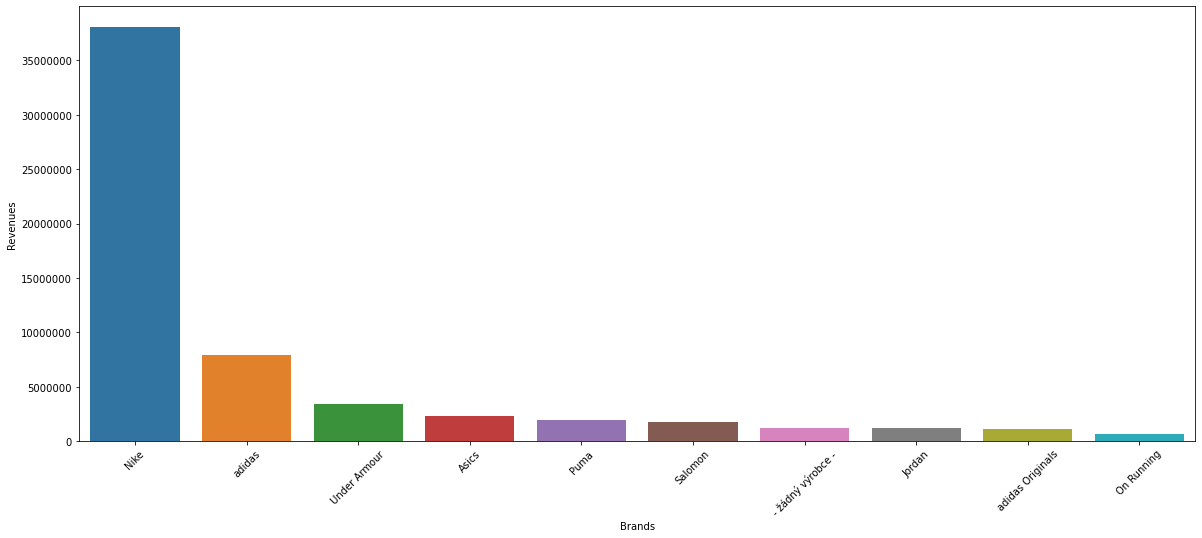

In [52]:
# Let's see from which brands the top4sport makes more money. 
brand_revenues=viz_df[['name', 'net_revenue']]
brand_revenues=brand_revenues.groupby(['name'])['net_revenue'].sum().reset_index().sort_values(by='net_revenue', ascending=False)

plt.figure(figsize=(20, 8))
sns.barplot(x=brand_revenues.name[:10], y=brand_revenues.net_revenue.values[:10])
plt.ylabel('Revenues')
plt.xlabel('Brands')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

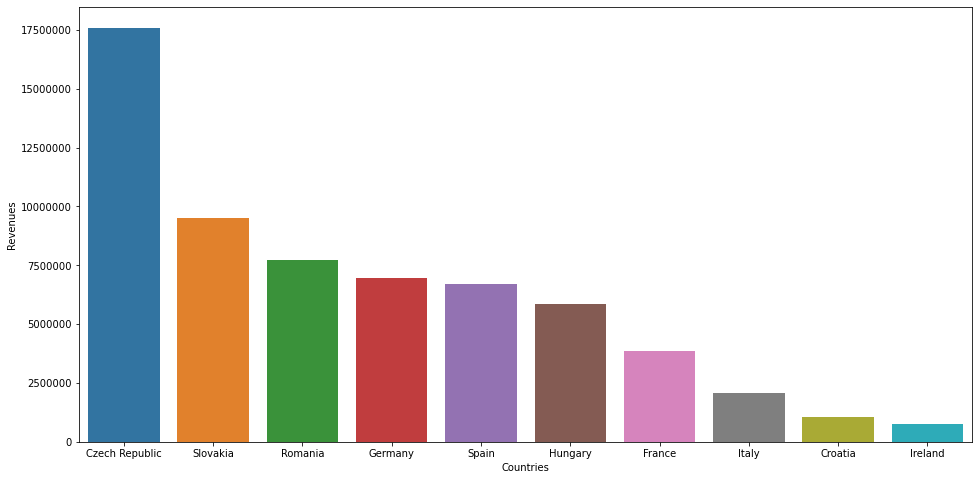

In [53]:
# Let's see from which country the top4sport makes more money. 
revenues_country=viz_df[['country', 'net_revenue']]
revenues_country=revenues_country.groupby(['country'])['net_revenue'].sum().reset_index().sort_values(by='net_revenue', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(x=revenues_country.country[:10], y=revenues_country.net_revenue[:10])
plt.ylabel('Revenues')
plt.xlabel('Countries')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

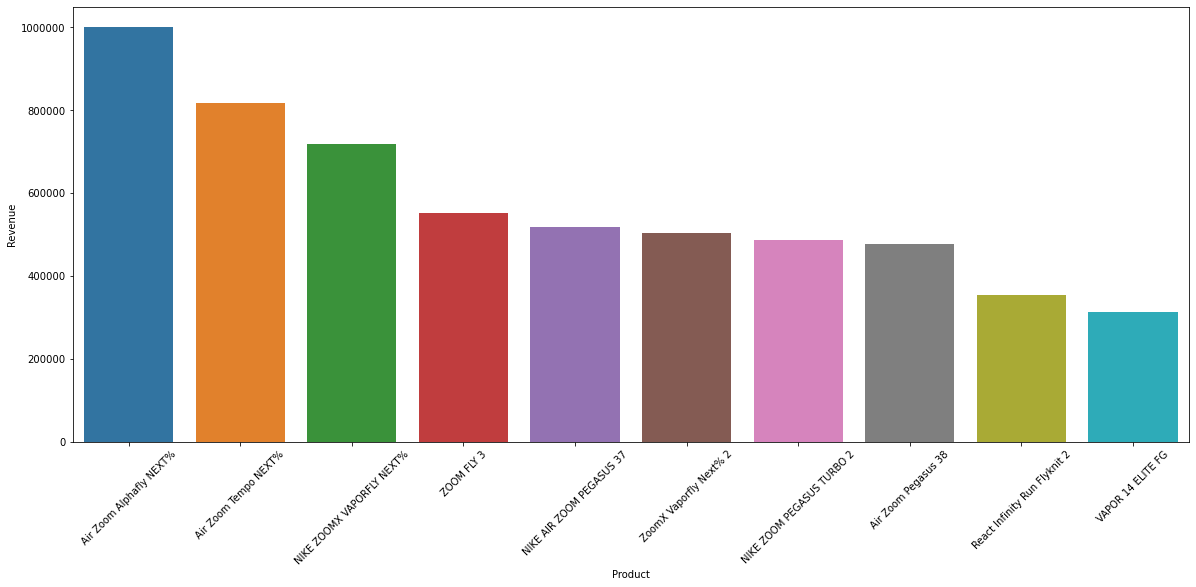

In [54]:
# Most popular product
product_revenue=viz_df[['item_name', 'net_revenue']]
product_revenue=product_revenue.groupby(['item_name'])['net_revenue'].sum().reset_index().sort_values(by='net_revenue', ascending=False)

plt.figure(figsize=(20, 8))
sns.barplot(x=product_revenue.item_name[1:11], y=product_revenue.net_revenue[1:11])
plt.ylabel('Revenue')
plt.xlabel('Product')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.show()

## Time Series Creation Functions

In [94]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'profit':'net_profit'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [124]:
def create_ts_dt_feat(ts_df):
    ts_df['year'] = ts_df['date'].dt.year
    ts_df['month'] = ts_df['date'].dt.month
    ts_df['day'] = ts_df['date'].dt.day
    ts_df['weekofyear'] = ts_df['date'].dt.week
    ts_df['weekday'] = ts_df['date'].dt.weekday
    ts_df['weekday'] = np.where(ts_df.weekday == 0, 7, ts_df.weekday)
    return ts_df

In [57]:
def create_ts_lag_feat(ts_df, n_lag):
    for lag in range(1, n_lag+1):
        ts_df[f'lag_{lag}'] = ts_df.iloc[:, 1].shift(lag)
    ts_df = ts_df.iloc[n_lag: , :]
    return ts_df

## Net Revenue Timeseries Analysis

In [58]:
ts_df=select_series(viz_df, 'day', 'net')

In [59]:
test_ts_df=create_ts_lag_feat(ts_df, 7)
test_ts_df.head()

,date,net_revenue,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,2019-06-08,41.066279,10914.593420,18990.873014,66236.436269,70505.743012,1307.299902,48.754263,4062.616362
8,2019-06-09,0.000000,41.066279,10914.593420,18990.873014,66236.436269,70505.743012,1307.299902,48.754263
9,2019-06-10,36197.568946,0.000000,41.066279,10914.593420,18990.873014,66236.436269,70505.743012,1307.299902
10,2019-06-11,46859.399789,36197.568946,0.000000,41.066279,10914.593420,18990.873014,66236.436269,70505.743012
11,2019-06-12,6347.609510,46859.399789,36197.568946,0.000000,41.066279,10914.593420,18990.873014,66236.436269


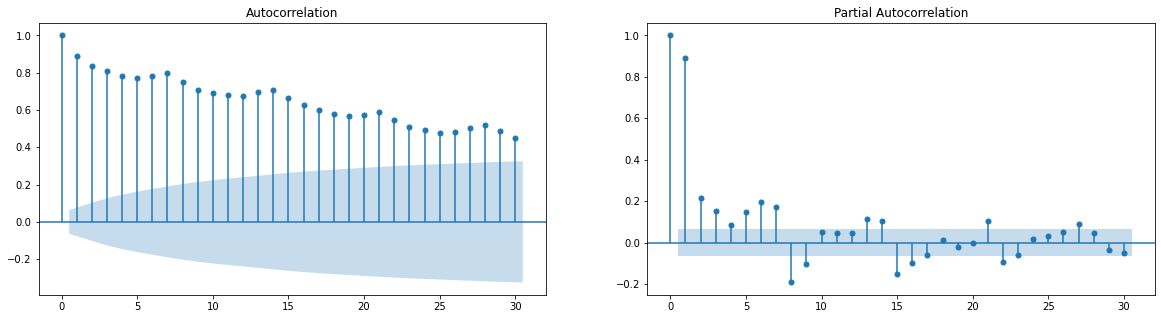

In [60]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(test_ts_df['net_revenue'], lags=30, ax=ax[0])
plot_pacf(test_ts_df['net_revenue'], lags=30, ax=ax[1])
plt.show()

In [61]:
ts_df=select_series(viz_df, 'week', 'net')

In [62]:
test_ts_df=create_ts_lag_feat(ts_df, 7)

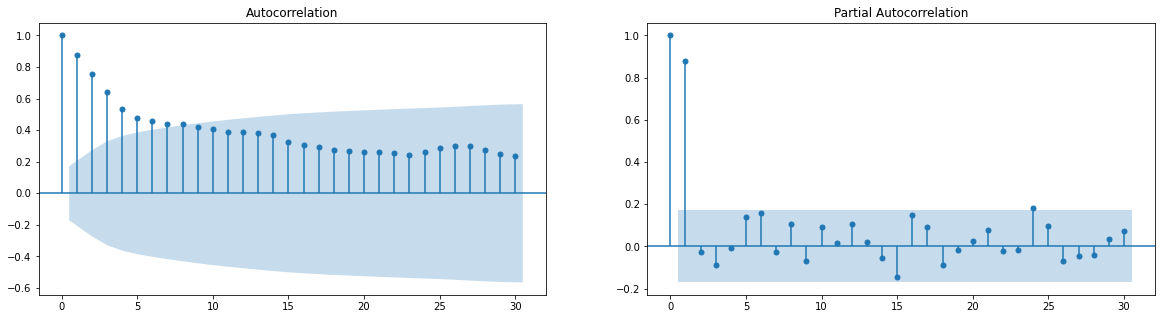

In [339]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(test_ts_df['net_revenue'], lags=30, ax=ax[0])
plot_pacf(test_ts_df['net_revenue'], lags=30, ax=ax[1])
plt.show()

In [63]:
ts_df=select_series(viz_df, 'month', 'net')

In [64]:
test_ts_df=create_ts_lag_feat(ts_df, 7)

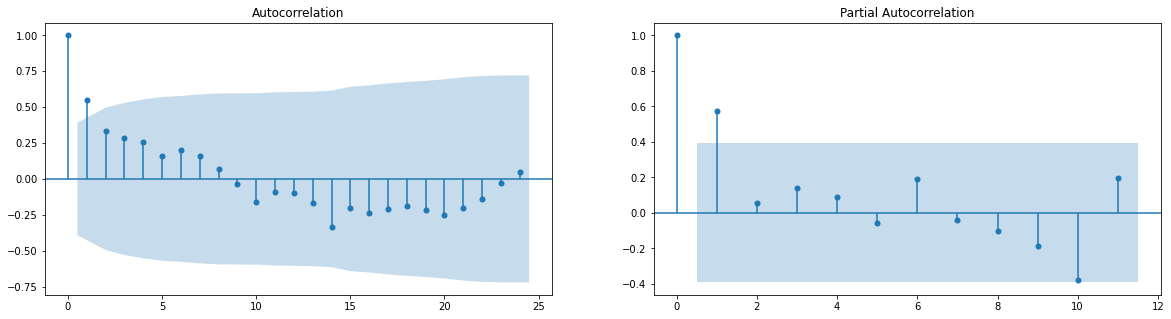

In [65]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(test_ts_df['net_revenue'], lags=24, ax=ax[0])
plot_pacf(test_ts_df['net_revenue'], lags=11, ax=ax[1])
plt.show()

## Gross Revenue Timeseries Analysis

In [90]:
ts_df=select_series(viz_df, 'day', 'gross')
test_ts_df=create_ts_lag_feat(ts_df, 7)
test_ts_df.head()

,date,gross_revenue,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,2019-06-08,74.251938,26.197070,213.893662,20.726356,53708.377730,1862.290679,53.719380,5863.757742
8,2019-06-09,0.000000,74.251938,26.197070,213.893662,20.726356,53708.377730,1862.290679,53.719380
9,2019-06-10,390.625154,0.000000,74.251938,26.197070,213.893662,20.726356,53708.377730,1862.290679
10,2019-06-11,63085.549011,390.625154,0.000000,74.251938,26.197070,213.893662,20.726356,53708.377730
11,2019-06-12,8581.764848,63085.549011,390.625154,0.000000,74.251938,26.197070,213.893662,20.726356


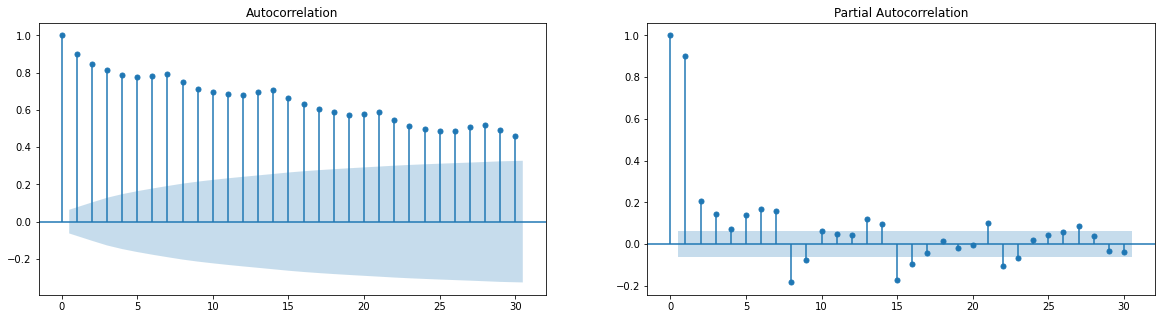

In [71]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(test_ts_df['gross_revenue'], lags=30, ax=ax[0])
plot_pacf(test_ts_df['gross_revenue'], lags=30, ax=ax[1])
plt.show()

In [72]:
ts_df=select_series(viz_df, 'week', 'gross')
test_ts_df=create_ts_lag_feat(ts_df, 7)

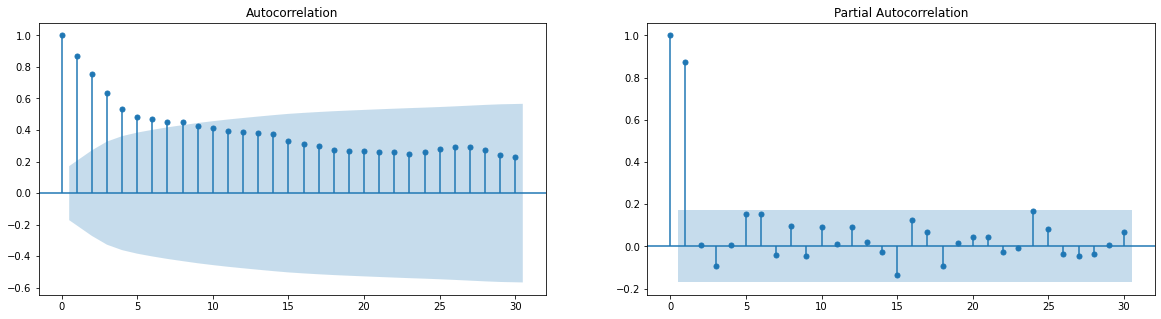

In [73]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(test_ts_df['gross_revenue'], lags=30, ax=ax[0])
plot_pacf(test_ts_df['gross_revenue'], lags=30, ax=ax[1])
plt.show()

In [113]:
ts_df=select_series(viz_df, 'month', 'gross')
test_ts_df=create_ts_lag_feat(ts_df, 7)

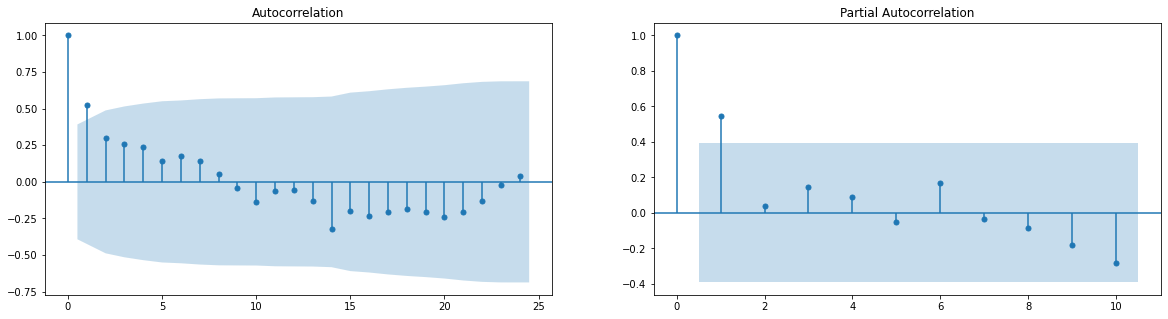

In [114]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(test_ts_df['gross_revenue'], lags=24, ax=ax[0])
plot_pacf(test_ts_df['gross_revenue'], lags=10, ax=ax[1])
plt.show()

## Profit Margin Time Series Analysis

In [95]:
ts_df=select_series(viz_df, 'day', 'profit')
test_ts_df=create_ts_lag_feat(ts_df, 7)
test_ts_df.head()

,date,net_profit,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,2019-06-08,7.424418,5643.125590,9820.378827,45663.395572,28270.822081,487.251452,15.872480,1820.957448
8,2019-06-09,0.000000,7.424418,5643.125590,9820.378827,45663.395572,28270.822081,487.251452,15.872480
9,2019-06-10,19322.957705,0.000000,7.424418,5643.125590,9820.378827,45663.395572,28270.822081,487.251452
10,2019-06-11,23223.812968,19322.957705,0.000000,7.424418,5643.125590,9820.378827,45663.395572,28270.822081
11,2019-06-12,3678.102533,23223.812968,19322.957705,0.000000,7.424418,5643.125590,9820.378827,45663.395572


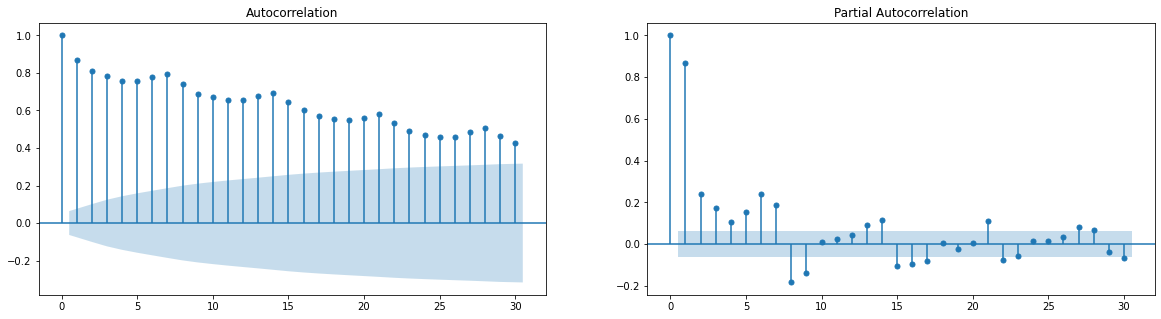

In [96]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(test_ts_df['net_profit'], lags=30, ax=ax[0])
plot_pacf(test_ts_df['net_profit'], lags=30, ax=ax[1])
plt.show()

In [97]:
ts_df=select_series(viz_df, 'week', 'profit')
test_ts_df=create_ts_lag_feat(ts_df, 7)
test_ts_df.head()

,date,net_profit,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,2019-07-21,105598.664347,118496.281441,95389.817844,70234.049787,118368.824008,70551.803374,89892.397941,1836.829928
8,2019-07-28,105882.086320,105598.664347,118496.281441,95389.817844,70234.049787,118368.824008,70551.803374,89892.397941
9,2019-08-04,135913.409508,105882.086320,105598.664347,118496.281441,95389.817844,70234.049787,118368.824008,70551.803374
10,2019-08-11,141156.809945,135913.409508,105882.086320,105598.664347,118496.281441,95389.817844,70234.049787,118368.824008
11,2019-08-18,130633.351462,141156.809945,135913.409508,105882.086320,105598.664347,118496.281441,95389.817844,70234.049787


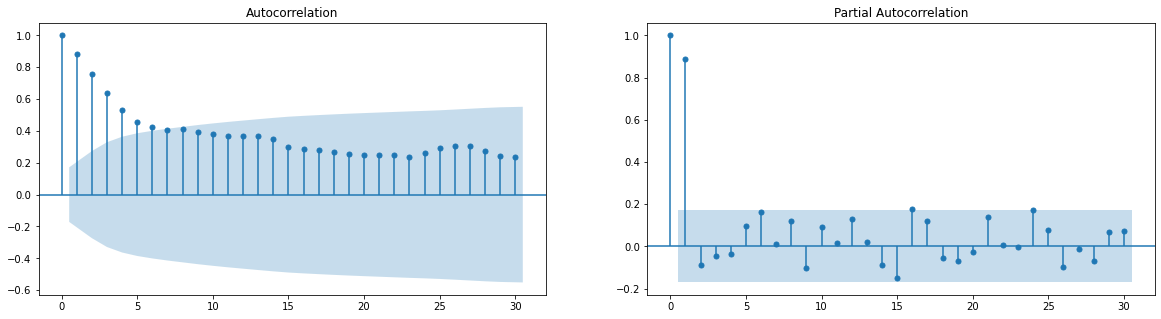

In [98]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(test_ts_df['net_profit'], lags=30, ax=ax[0])
plot_pacf(test_ts_df['net_profit'], lags=30, ax=ax[1])
plt.show()

In [111]:
ts_df=select_series(viz_df, 'month', 'profit')
test_ts_df=create_ts_lag_feat(ts_df, 7)
test_ts_df.head()

,date,net_profit,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,2020-01-31,525283.416617,693573.990210,646634.177140,418621.757171,502120.734679,578379.878571,491557.473993,350883.905038
8,2020-02-29,481911.382517,525283.416617,693573.990210,646634.177140,418621.757171,502120.734679,578379.878571,491557.473993
9,2020-03-31,458333.430592,481911.382517,525283.416617,693573.990210,646634.177140,418621.757171,502120.734679,578379.878571
10,2020-04-30,516308.264583,458333.430592,481911.382517,525283.416617,693573.990210,646634.177140,418621.757171,502120.734679
11,2020-05-31,724966.536443,516308.264583,458333.430592,481911.382517,525283.416617,693573.990210,646634.177140,418621.757171


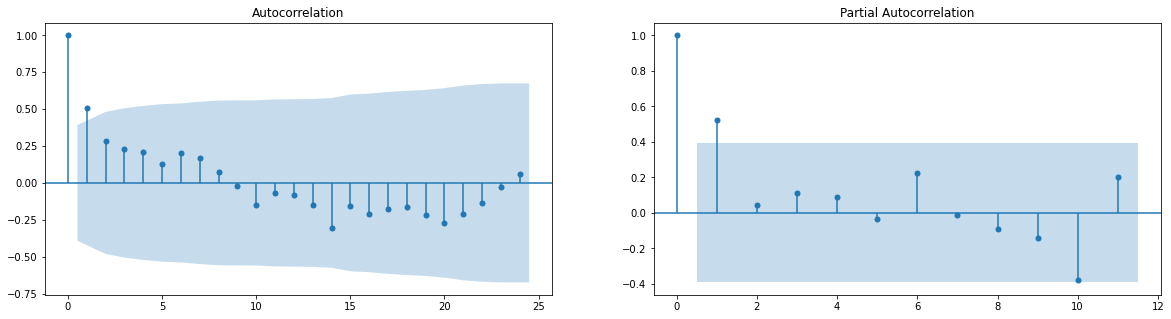

In [112]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(test_ts_df['net_profit'], lags=24, ax=ax[0])
plot_pacf(test_ts_df['net_profit'], lags=11, ax=ax[1])
plt.show()

## Time Series Visualizations

In [133]:
# change weekday column names for graph visualization
ts_viz_df = select_series(viz_df, 'day', 'net')
ts_viz_df = create_ts_dt_feat(ts_viz_df)
ts_viz_df['weekday']=ts_viz_df['weekday'].replace({1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'})

[Text(0.5, 1.0, 'Average Net Revenue Per Day of Week')]

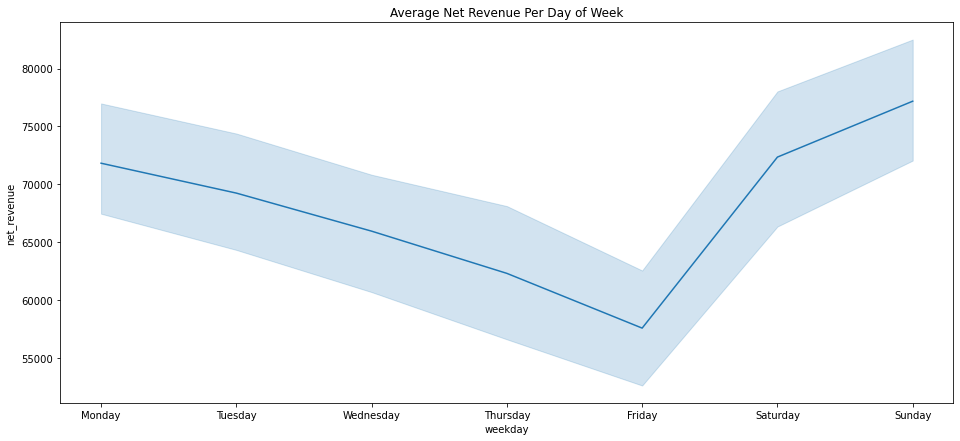

In [159]:
plt.figure(figsize=(16,7))
first_monday = (ts_viz_df['weekday']=='Monday').idxmax()
plot = sns.lineplot(x='weekday', y='net_revenue', data=ts_viz_df[first_monday:])
plot.set(title='Average Net Revenue Per Day of Week')

In [190]:
ts_viz_df = select_series(viz_df, 'week', 'net')
ts_viz_df = create_ts_dt_feat(ts_viz_df).groupby('weekofyear').mean()

[Text(0.5, 1.0, 'Average Net Revenue Per Week')]

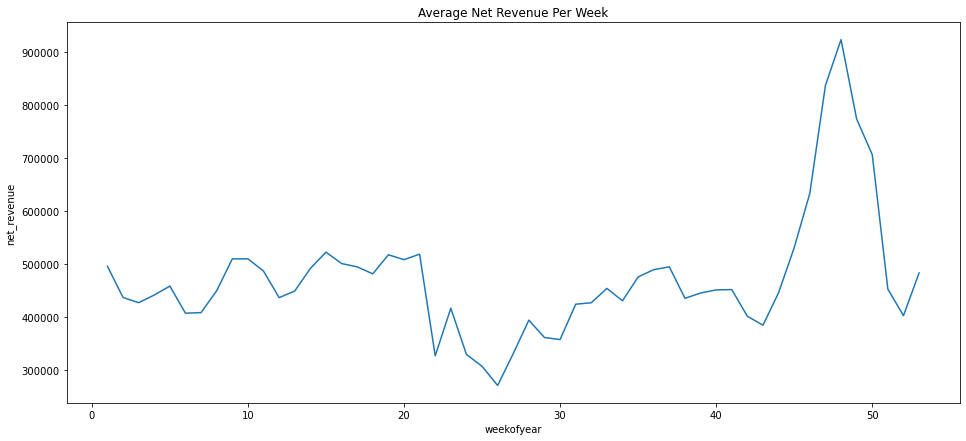

In [191]:
plt.figure(figsize=(16,7))
plot = sns.lineplot(x='weekofyear', y='net_revenue', data=ts_viz_df)
plot.set(title='Average Net Revenue Per Week')

In [192]:
ts_viz_df = select_series(viz_df, 'month', 'net')
ts_viz_df = create_ts_dt_feat(ts_viz_df).groupby('weekofyear').mean()

[Text(0.5, 1.0, 'Average Net Revenue Per Month')]

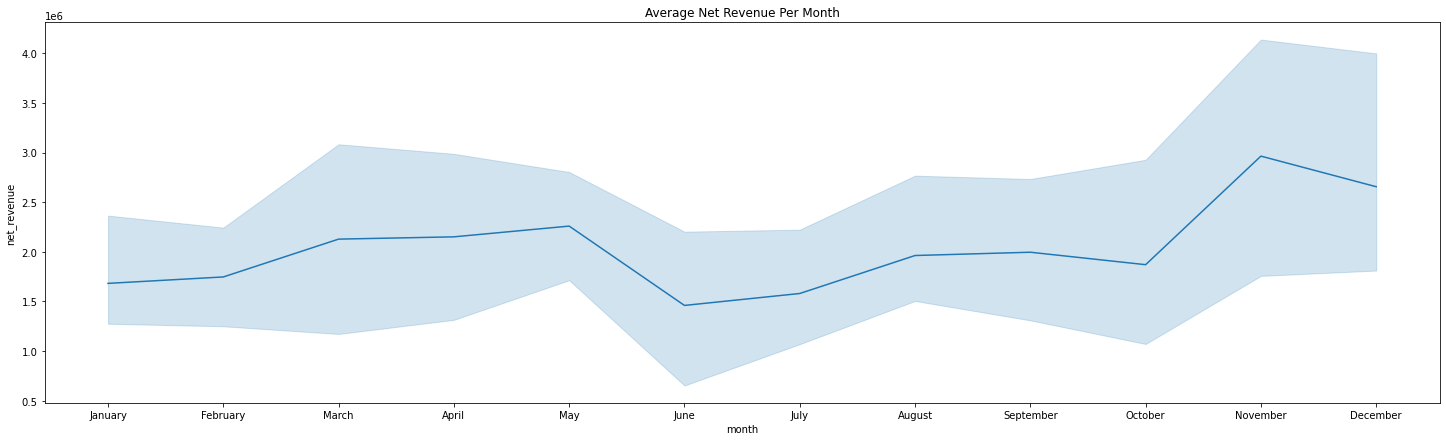

In [178]:
plt.figure(figsize=(25,7))
plot = sns.lineplot(x='month', y='net_revenue', data=ts_viz_df)
plot.xaxis.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
plot.set_xticklabels(labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                             'September', 'October', 'November', 'December'])
plot.set(title='Average Net Revenue Per Month')